In [2]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [3]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [4]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [6]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [8]:
########################### Load Data
#################################################################################
print('Load Main Data')

data_path = "/Volumes/ExtData/datasets/m5-forecasting-accuracy"

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv(f'{data_path}/sales_train_validation.csv')
prices_df = pd.read_csv(f'{data_path}/sell_prices.csv')
calendar_df = pd.read_csv(f'{data_path}/calendar.csv')

Load Main Data


## Explore data a bit first!

In [44]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [57]:
train_df.item_id.unique()t

array(['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', ...,
       'FOODS_3_825', 'FOODS_3_826', 'FOODS_3_827'], dtype=object)

<AxesSubplot:>

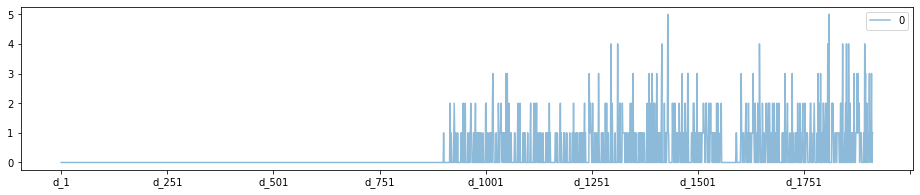

In [58]:
dates = [f"d_{d}" for d in range(1, 1914)]
train_df.iloc[:1][dates].T.plot(figsize=(16,3), alpha=0.5)

In [11]:
prices_df

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [12]:
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [7]:
########################### Make Grid
#################################################################################
print('Create Grid')

# We can tranform horizontal representation 
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# If we look on train_df we se that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df), len(grid_df))

# To be able to make predictions
# we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df
# anymore and can remove it
del train_df

# You don't have to use df = df construction
# you can use inplace=True instead.
# like this
# grid_df.reset_index(drop=True, inplace=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Create Grid
Train rows: 30490 58327370
    Original grid_df:   3.5GiB
     Reduced grid_df:   1.3GiB


In [8]:
########################### Product Release date
#################################################################################
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# absence for the item in the store
# we can safe some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']

# Now we can merge release_df
grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
del release_df

# We want to remove some "zeros" rows
# from grid_df 
# to do it we need wm_yr_wk column
# let's merge partly calendar_df to have it
grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])
                      
# Now we can cutoff some rows 
# and safe memory 
grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# Should we keep release week 
# as one of the features?
# Only good CV can give the answer.
# Let's minify the release values.
# Min transformation will not help here 
# as int16 -> Integer (-32768 to 32767)
# and our grid_df['release'].max() serves for int16
# but we have have an idea how to transform 
# other columns in case we will need it
grid_df['release'] = grid_df['release'] - grid_df['release'].min()
grid_df['release'] = grid_df['release'].astype(np.int16)

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Release week
    Original grid_df:   1.7GiB
     Reduced grid_df:   1.5GiB


In [9]:
########################### Save part 1
#################################################################################
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
grid_df.to_pickle('grid_part_1.pkl')

print('Size:', grid_df.shape)

Save Part 1
Size: (46881677, 10)


In [10]:
########################### Prices
#################################################################################
print('Prices')

# We can do some basic aggregations
prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# and do price normalization (min/max scaling)
prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

# Some items are can be inflation dependent
# and some items are very "stable"
prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

# I would like some "rolling" aggregations
# but would like months and years as "window"
calendar_prices = calendar_df[['wm_yr_wk','month','year']]
calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
del calendar_prices

# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

del prices_df['month'], prices_df['year']

Prices


In [11]:
########################### Merge prices and save part 2
#################################################################################
print('Merge prices and save part 2')

# Merge Prices
original_columns = list(grid_df)
grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(grid_df) if col not in original_columns]
grid_df = grid_df[MAIN_INDEX+keep_columns]
grid_df = reduce_mem_usage(grid_df)

# Safe part 2
grid_df.to_pickle('grid_part_2.pkl')
print('Size:', grid_df.shape)

# We don't need prices_df anymore
del prices_df

# We can remove new columns
# or just load part_1
grid_df = pd.read_pickle('grid_part_1.pkl')

Merge prices and save part 2
Mem. usage decreased to 1789.88 Mb (62.2% reduction)
Size: (46881677, 13)


In [12]:
########################### Merge calendar
#################################################################################
grid_df = grid_df[MAIN_INDEX]

# Merge calendar partly
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']

grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

# Minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']
for col in icols:
    grid_df[col] = grid_df[col].astype('category')

# Convert to DateTime
grid_df['date'] = pd.to_datetime(grid_df['date'])

# Make some features from date
grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
grid_df['tm_y'] = grid_df['date'].dt.year
grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

# Remove date
del grid_df['date']

In [13]:
########################### Save part 3 (Dates)
#################################################################################
print('Save part 3')

# Safe part 3
grid_df.to_pickle('grid_part_3.pkl')
print('Size:', grid_df.shape)

# We don't need calendar_df anymore
del calendar_df
del grid_df

Save part 3
Size: (46881677, 16)


In [14]:
########################### Some additional cleaning
#################################################################################

## Part 1
# Convert 'd' to int
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)

# Remove 'wm_yr_wk'
# as test values are not in train set
del grid_df['wm_yr_wk']
grid_df.to_pickle('grid_part_1.pkl')

del grid_df

In [15]:
########################### Summary
#################################################################################

# Now we have 3 sets of features
grid_df = pd.concat([pd.read_pickle('grid_part_1.pkl'),
                     pd.read_pickle('grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
                     
# Let's check again memory usage
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
print('Size:', grid_df.shape)

# 2.5GiB + is is still too big to train our model
# (on kaggle with its memory limits)
# and we don't have lag features yet
# But what if we can train by state_id or shop_id?
state_id = 'CA'
grid_df = grid_df[grid_df['state_id']==state_id]
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid:   1.2GiB

store_id = 'CA_1'
grid_df = grid_df[grid_df['store_id']==store_id]
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid: 321.2MiB

# Seems its good enough now
# In other kernel we will talk about LAGS features
# Thank you.

           Full Grid:   2.4GiB
Size: (46881677, 34)
           Full Grid:   1.1GiB
           Full Grid: 293.8MiB


In [16]:
########################### Final list of features
#################################################################################
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788267 entries, 0 to 46854235
Data columns (total 34 columns):
id                  category
item_id             category
dept_id             category
cat_id              category
store_id            category
state_id            category
d                   int16
sales               float64
release             int16
sell_price          float16
price_max           float16
price_min           float16
price_std           float16
price_mean          float16
price_norm          float16
price_nunique       float16
item_nunique        int16
price_momentum      float16
price_momentum_m    float16
price_momentum_y    float16
event_name_1        category
event_type_1        category
event_name_2        category
event_type_2        category
snap_CA             category
snap_TX             category
snap_WI             category
tm_d                int8
tm_w                int8
tm_m                int8
tm_y                int8
tm_wm               int